## 测试：将单个田块内的地头区域整合，让相邻的地头连接
#### 同时使用新的地块区域

In [2]:
import geopandas as gpd
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit, CPP_Algorithm_Optimizers
from shapely import affinity
from skimage.measure import approximate_polygon
import warnings
import math

In [3]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
# all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.05)
# 对当前 all_land 添加一个 mean_slope 字段 [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land['mean_slope'] = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
land_angle = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land

,NAME,LAYER,周长,闭合面积,geometry,mean_slope
0,1,Unknown Area Type,431.18 m,0.003934 sq km,"POLYGON ((440340.400 4397545.529, 440362.512 4...",3.37
1,2,Unknown Area Type,313.38 m,0.00176 sq km,"POLYGON ((440345.271 4397525.674, 440407.011 4...",7.38
2,3,Unknown Area Type,181.21 m,0.001529 sq km,"POLYGON ((440474.831 4397334.155, 440485.186 4...",6.07
3,4,Unknown Area Type,246.79 m,0.001229 sq km,"POLYGON ((440475.542 4397712.792, 440483.155 4...",3.94
4,5,Unknown Area Type,144.76 m,0.000756 sq km,"POLYGON ((440454.143 4397794.039, 440456.139 4...",6.53
5,6,Unknown Area Type,118.5 m,0.000631 sq km,"POLYGON ((440357.683 4397817.534, 440364.942 4...",7.46
6,7,Unknown Area Type,147.38 m,0.001212 sq km,"POLYGON ((440313.829 4397831.971, 440317.080 4...",7.62


split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  9
Num of Polygon lines:  14
Not on Convex:  6


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


<Axes: >

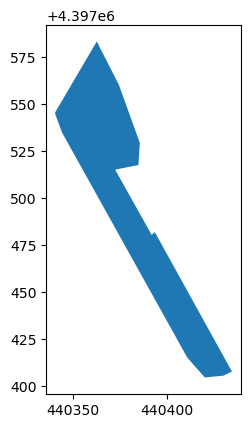

In [4]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 0)
single_angle = land_angle[6]
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.05)
single_land.plot()

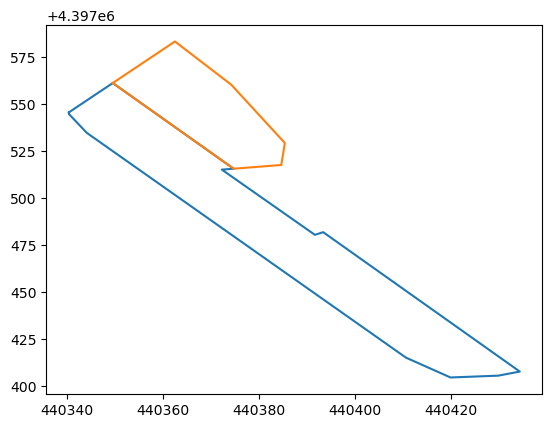

In [5]:
_, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)

#### 现在将所有的分割的地块区域路径规划后的地头区域尝试整合

In [6]:
swath_width = 1.45
vehicle_length = 4.5
vehicle_width = 1.9
turning_radius = 4.5

headland_width, vehicle_theta = CPP_Planner_Kit.calc_headland_width(turning_radius, swath_width, vehicle_length, vehicle_width, buffer=0.3, show_info=True)

all_land_path = []
all_headland = []
for polygon in split_polygon:
    if polygon.area > 20:
        polygon_regen = gpd.GeoDataFrame(geometry=[polygon], crs=all_land.crs)
        polygon_centroid = polygon_regen.centroid[0]
        temp_path, temp_headland, theta = CPP_Algorithm_Optimizers.gen_path_with_minimum_headland_area_by_edge(
            polygon_regen, swath_width, headland_width, headland_mode='both', return_theta=True
        )
        all_land_path.append(temp_path)
        all_headland.append(temp_headland)

Theta:  0.6682897949014295
r2:  5.896185207403173
Theta2:  0.39152955266108685
w2: 5.1430486795724795
Buffer:  0.3
最终地头宽度:  7.693048679572479


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_unio

In [7]:
# 处理 headland 里的 multipolygon 为单独的 polygon
single_polygon_headland = []
for item in all_headland:
    temp_item = item.geometry[0]
    if type(temp_item) == shapely.MultiPolygon:
        for polygon in temp_item.geoms:
            if polygon.area > 10:
                single_polygon_headland.append(polygon)
    elif type(temp_item) == shapely.Polygon:
        if temp_item.area > 10:
            single_polygon_headland.append(temp_item)

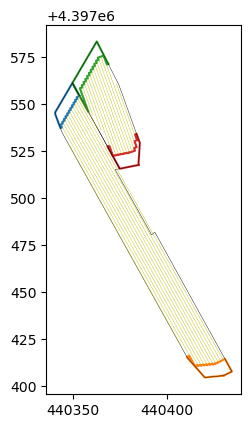

In [26]:
# 显示
_, ax = plt.subplots()
for polygon in single_polygon_headland:
    ax.plot(*polygon.exterior.xy)
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy, color='black', linewidth=0.3)
for path in all_land_path:
    path.plot(ax=ax, color='y', linewidth=0.3)
ax.set_aspect('equal')

In [9]:
# 消除过大的毛边，同时测试是否能够相交
single_polygon_headland[0].intersects(single_polygon_headland[2].buffer(0.3))

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


True

<class 'shapely.geometry.polygon.Polygon'>


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


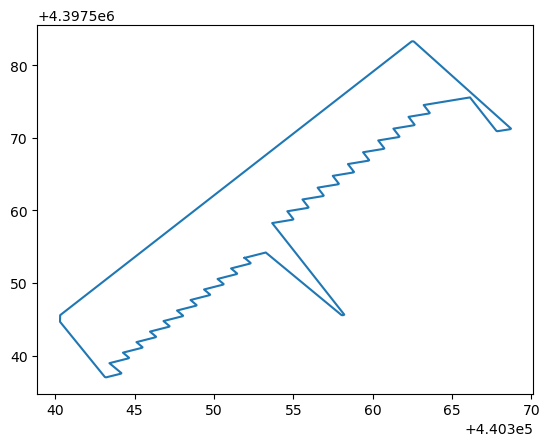

In [10]:
# plt.plot(*single_polygon_headland[2].exterior.xy)
# 将两个区域融合
union_headland = ops.unary_union([single_polygon_headland[0].buffer(0.1), single_polygon_headland[2].buffer(0.1)])
print(type(union_headland))
plt.plot(*union_headland.exterior.xy)

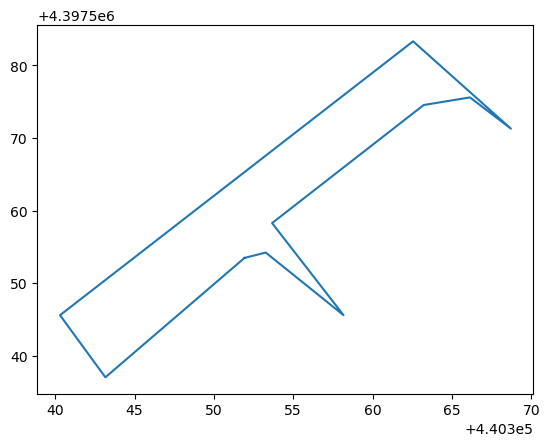

In [11]:
smooth_headlands = union_headland.simplify(1.45)
plt.plot(*smooth_headlands.exterior.xy)

In [12]:
# 仅保留较大的多边形
bigger_headlands = CPP_Planner_Kit.split_polygon_by_largest_area(smooth_headlands)
bigger_headlands

split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.03
Num of convex_hull:  5
Num of Polygon lines:  10
Not on Convex:  7
Num of convex_hull:  3
Num of Polygon lines:  5
Not on Convex:  3
Num of convex_hull:  3
Num of Polygon lines:  4
Not on Convex:  2


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


[<POLYGON ((440351.926 4397553.465, 440343.164 4397537.008, 440340.309 439754...>,
 <POLYGON ((440365.131 4397578.266, 440366.441 4397575.706, 440366.126 439757...>,
 <POLYGON ((440366.441 4397575.706, 440368.705 4397571.283, 440366.126 439757...>,
 <POLYGON ((440363.21 4397574.541, 440362.54 4397573.401, 440363.133 4397574....>,
 <POLYGON ((440353.991 4397557.343, 440358.16 4397545.58, 440353.261 4397554....>,
 <POLYGON ((440353.261 4397554.208, 440351.926 4397553.465, 440352.777 439755...>]

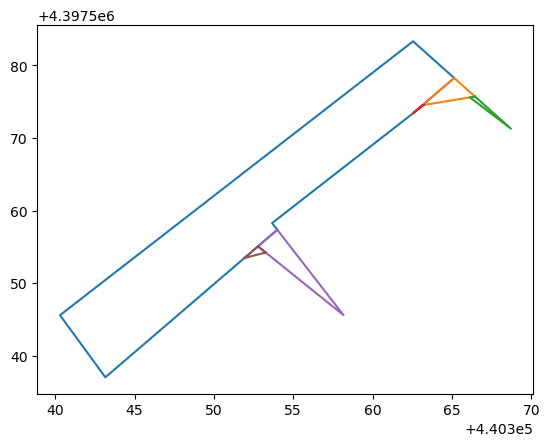

In [13]:
_, ax = plt.subplots()
for polygon in bigger_headlands:
    ax.plot(*polygon.exterior.xy)

In [14]:
# 去掉面积过小的地头
good_headlands = []
for polygon in bigger_headlands:
    if polygon.area > 20:
        good_headlands.append(polygon)
good_headlands

[<POLYGON ((440351.926 4397553.465, 440343.164 4397537.008, 440340.309 439754...>]

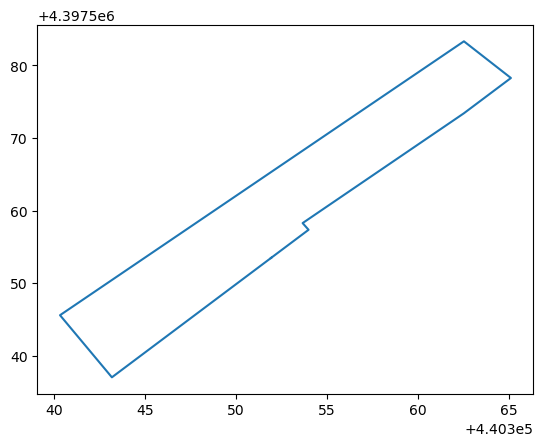

In [15]:
_, ax = plt.subplots()
for polygon in good_headlands:
    ax.plot(*polygon.exterior.xy)

In [16]:
headland_gdf = gpd.GeoDataFrame(geometry=[good_headlands[0]], crs=all_land.crs)
# 继续进行路径规划
headland_path, headland_headland = CPP_Algorithm_Optimizers.gen_path_with_minimum_headland_area_by_edge(
    headland_gdf, swath_width, head_land_width=0, headland_mode='none'
)

/Users/outianyi/PythonProject/Coverage_Path_Planning/CPP_Planner.py:590: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  path_buffer_1 = path_gdf.buffer(step_size + 0.2, single_sided=True).unary_union
/Users/outianyi/PythonProject/Coverage_Path_Planning/CPP_Planner.py:591: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  path_buffer_2 = path_gdf.buffer(-(step_size + 0.2), single_sided=True).unary_union
/Users/outianyi/PythonProject/Coverage_Path_Planning/CPP_Planner.py:593: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  path_area_union = path_buffer.unary_union
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encounte

<Axes: >

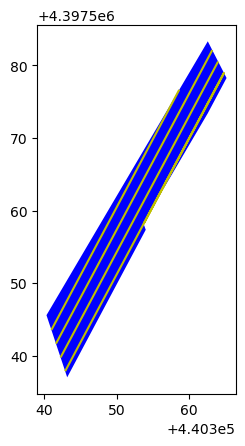

In [17]:
_, ax = plt.subplots()
headland_gdf.plot(ax=ax, color='b')
headland_path.plot(ax=ax, color='y')

In [18]:
a = [1, 2, 3, 4, 5]
del a[2]
a

[1, 2, 4, 5]

In [19]:
from CPP_Planner import CPP_Planner_TurningRail_Maker
path_result = CPP_Planner_TurningRail_Maker.combine_headlands_gen_path(all_headland, swath_width, headland_width,
                                                                       headland_mode='none', area_limit=20)


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:881: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, 

Combining headlands in one field...
split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  71
Num of Polygon lines:  133
Not on Convex:  65
Num of convex_hull:  36
Num of Polygon lines:  64
Not on Convex:  29
Num of convex_hull:  30
Num of Polygon lines:  36
Not on Convex:  7
split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  70
Num of Polygon lines:  82
Not on Convex:  13
split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  69
Num of Polygon lines:  97
Not on Convex:  29


/Users/outianyi/PythonProject/Coverage_Path_Planning/CPP_Planner.py:590: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  path_buffer_1 = path_gdf.buffer(step_size + 0.2, single_sided=True).unary_union
/Users/outianyi/PythonProject/Coverage_Path_Planning/CPP_Planner.py:591: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  path_buffer_2 = path_gdf.buffer(-(step_size + 0.2), single_sided=True).unary_union
/Users/outianyi/PythonProject/Coverage_Path_Planning/CPP_Planner.py:593: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  path_area_union = path_buffer.unary_union
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encounte

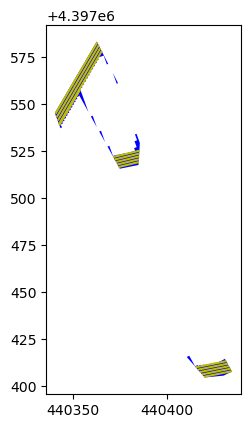

In [20]:
_, ax = plt.subplots()
for item in all_headland:
    item.plot(ax=ax, color='b')
for path in path_result:
    path.plot(ax=ax, color='y')

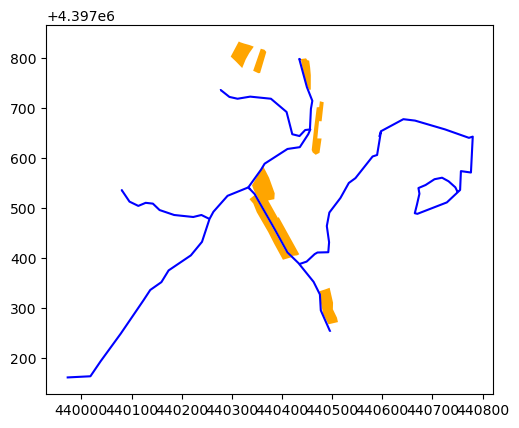

In [21]:
all_road = gpd.read_file('test_Load_Shp/shp_file/村地和道路/村地道路.shp')
_, ax = plt.subplots()
all_road.plot(ax=ax, color='b')
all_land.plot(ax=ax, color='orange')
ax.set_aspect('equal')

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


<Axes: >

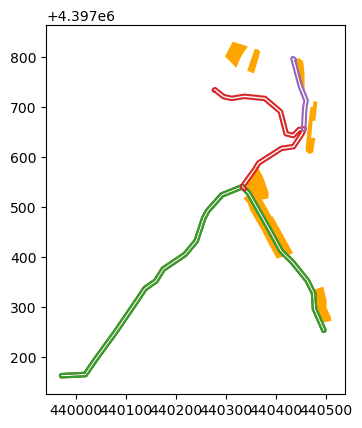

In [22]:
# 添加缓冲区
all_road_buffer = all_road.buffer(3.5)
# 仅保留与地块相交的道路
road_contact = []
for road in all_road_buffer.geometry:
    for land in all_land.geometry:
        if road.intersects(land):
            road_contact.append(road)
# 显示
_, ax = plt.subplots()
for road in road_contact:
    ax.plot(*road.exterior.xy)
all_land.plot(ax=ax, color='orange')